In [1]:
# load module
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import wntr
import wntr_utils
from sklearn.preprocessing import MinMaxScaler
from random import shuffle
import csv
import random

In [3]:
# load STREaM data (STREaM is a simulator of end-uses and water demand patterns)
# This dataset contains 3 years of hourly (26280 data points) synthetic demand data 
# for 4 user_classes = ['low','average','high','morning','night']. There are 500 user for each class,
# with the first 10 users having leaks. We need to remove these users for our purposes. 

all_data_path = './data/allData.txt'
df = pd.read_csv(all_data_path, header=None)
# 
# create headers
user_classes = ['low','average','high','morning','night']
headers = []
for user_class in user_classes:
    suffixes = (('_'+user_class+' ')*400).split() # original
    for suffix, number in zip(suffixes,range(1,401)):
        headers.append('user'+suffix+'_'+'%03d'%number)  
        
# reverse df and change df columns
df = df.T
df.columns = headers

# remove first 10 of each class (these have leaks, so not useful for our purposes)
users_to_remove = np.array(headers).reshape(-1,10)[::40].ravel().tolist()
df.drop(users_to_remove, axis = 1, inplace = True)
headers = df.columns

In [4]:
# this function creates a hourly pattern of multipliers (up to 26280 hours long) mixing together n (max 1950) patterns
# from the STREaM dataset; it scales within a range (as expected for WNTR/EPANET input)
def create_demand_pattern(df_patterns, n_hours=168, n_mix=50, bound = [0.3,0.9], noise_intensity=0.01):
    cols =df_patterns.columns.to_list()
    shuffle(cols)
    df_patterns = df_patterns[cols]
    s = MinMaxScaler(bound)
    temp=np.squeeze(s.fit_transform(df_patterns.iloc[:n_hours,:n_mix].mean(axis=1).values.reshape(-1,1)))
    dem_pat = temp + np.random.randn(n_hours)*noise_intensity
    return dem_pat

In [5]:
# load EPANET model
inp_file = 'minitown_map.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# save original patterns
names, patterns =[],[]
for name, pat in wn.patterns():
    names.append(name)
    patterns.append(pat.multipliers)
df_pat_orig = pd.DataFrame(data = patterns).T
df_pat_orig.columns = names

C:\Users\Azulm\Anaconda3\lib\site-packages\wntr\epanet\io.py:2085: UserWarning: Not all curves were used in "minitown_map.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(self.wn.name))


In [7]:
# Generate a 3-year pattern for the District Metered Area (DMA)
names, patterns =[],[]
for name, pat in wn.patterns():
    names.append(name)
    temp = create_demand_pattern(df, n_hours=24*365*3, n_mix=150)
    pat.multipliers = temp
    patterns.append(pat.multipliers)
df_pat_new = pd.DataFrame(data = patterns).T
df_pat_new.columns = names
df_pat_new.to_csv('three_year_demands_minitown.csv')

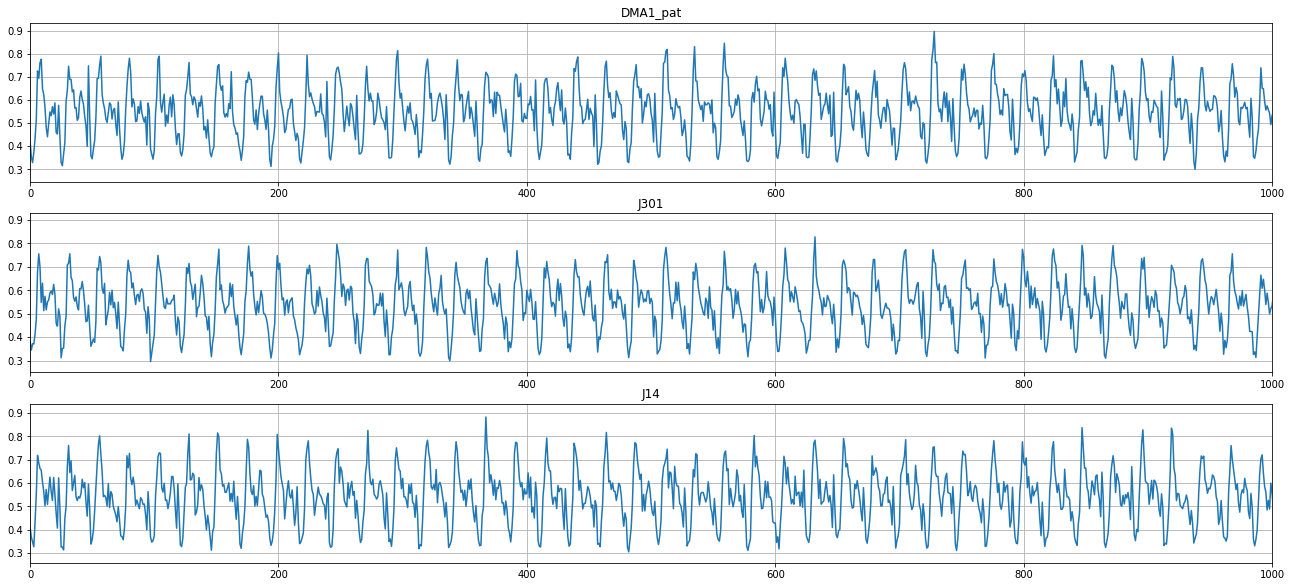

In [8]:
i=1
for pat_name in names:
    dd = plt.subplot(len(names),1,i)
    plt.plot(df_pat_new[pat_name], label="Demand")
    plt.title(pat_name)
    plt.subplots_adjust(top=2.00, right=3.00)
    plt.xlim(left=0, right=1000)
    plt.grid(True)
    i+=1

In [9]:
# Create a pandas dataframe with columns = each DMA pattern and 38 random initial pattern values
df_pat_new = pd.read_csv('three_year_demands_minitown.csv')
values=[]
weekly_simulation_duration = 168
ten_days_simulatino_duration = 240
weekly=False

if weekly:
    limit = weekly_simulation_duration
else:
    limit = ten_days_simulatino_duration

for i in range(0,38):
    value = random.randint(0, len(df_pat_new)-limit)        
    values.append(value)
pattern_random_init_point = pd.DataFrame(data = values)
pattern_random_init_point.columns = ['start']
print(pattern_random_init_point)
pattern_random_init_point.to_csv('minitown_starting_demand_points.csv')

    start
0    2422
1    2095
2   13469
3    1678
4   25584
5    8181
6    7889
7    1246
8   19849
9   26020
10   7502
11   7039
12   7944
13  25733
14  19769
15   9441
16   6172
17   2265
18   4953
19  19854
20  16474
21  19242
22  11734
23   7481
24   6751
25  15853
26   1572
27  14350
28  16219
29  18267
30   5503
31  23951
32    934
33   5617
34   4722
35  15064
36  16400
37  23008


In [11]:
# Create a pandas dataframe with initial tank levels for the 7 C-Town tanks and 38 weeks
values=[]
#tank_names = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7']
tank_names = ['TANK']
for name in tank_names:
    aux=[]
    for i in range(0,38):
        tank_max_value = wn.get_node(name).max_level
        min_value = tank_max_value*0.10
        max_value = tank_max_value*0.80
        value = random.uniform(min_value, max_value)        
        aux.append(value)
    values.append(aux)
tank_initial_levels = pd.DataFrame(data = values).T
tank_initial_levels.columns = tank_names
print(tank_initial_levels)
tank_initial_levels.to_csv('minitown_tank_initial_conditions.csv')

        TANK
0   2.080237
1   2.630407
2   5.047782
3   3.468502
4   1.994127
5   2.500606
6   4.321736
7   4.699887
8   0.727779
9   3.807217
10  1.969769
11  4.702631
12  0.950461
13  3.571292
14  4.054814
15  3.719258
16  4.694373
17  1.229693
18  2.635975
19  1.884763
20  3.183841
21  4.057362
22  1.098673
23  5.170248
24  2.770701
25  4.795422
26  4.153436
27  1.824133
28  5.024334
29  1.690211
30  3.218492
31  1.693152
32  4.497884
33  1.868102
34  1.884232
35  3.769127
36  4.482677
37  1.269929
